In [1]:
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    # specify the path of the folder containing "file_name" :
    path_to_file = '/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data/'
    print(path_to_file)
    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data/
/content/gdrive/My Drive/5153: Applied Machine Learning/LSTM Data


In [2]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
tf.random.set_seed(221)

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model
import math
import prediction_prep as prep

import warnings
warnings.filterwarnings('ignore')

## Load in Data

In [3]:
# READ IN ALL DATA
ticker = 'BB'
comments = pd.read_csv('comments_preprocessed_assigned.csv')
sentiment = pd.read_csv('df_pred_id_body.csv')
# fin_data = pd.read_csv(r'C:\Users\Nylle\`Assignments\LSTM\Stock\AMC_2021.csv')
fin_data = pd.read_csv('stock_data/{}_2021.csv'.format(ticker))

# Call custom function to get concatenated df with all features
df = prep.get_regression_df(ticker_name = str.lower(ticker),
                           comments = comments, 
                           fin_data = fin_data,
                           sentiment = sentiment)

# Set up a results dictionary object
results_dict = {}

df.head()

,date,comments_neutral,comments_positive,comment_count,pct_pos_comments,is_meme,comments_neutral_rollsum_2D,comments_neutral_rollmean_2D,comments_neutral_2D_pctchg,comments_positive_rollsum_2D,...,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD,day_of_week,SD_log
0,2021-01-01,2.0,1.0,3.0,33.332222,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
1,2021-01-02,2.0,1.0,3.0,33.332222,0,4.0,2.0,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
2,2021-01-03,3.0,0.0,3.0,0.000000,0,5.0,2.5,50.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
3,2021-01-04,0.0,0.0,0.0,0.000000,0,3.0,1.5,-100.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.299964,0,0.262337
4,2021-01-05,0.0,1.0,1.0,99.990001,0,0.0,0.0,-100.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.220911,1,-1.509996


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 100 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           366 non-null    datetime64[ns]
 1   comments_neutral               366 non-null    float64       
 2   comments_positive              366 non-null    float64       
 3   comment_count                  366 non-null    float64       
 4   pct_pos_comments               366 non-null    float64       
 5   is_meme                        366 non-null    int64         
 6   comments_neutral_rollsum_2D    365 non-null    float64       
 7   comments_neutral_rollmean_2D   365 non-null    float64       
 8   comments_neutral_2D_pctchg     344 non-null    float64       
 9   comments_positive_rollsum_2D   365 non-null    float64       
 10  comments_positive_rollmean_2D  365 non-null    float64       
 11  comments_positive_

## LSTM: CLOSE PRICE WITH SENTIMENT

### 1-Day Shift

In [5]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['2Dir', 'Daily%Change', '6Dir', 'Open', 'Low', '7D%Change', '5D%Change', '2D%Change', 'SD', '4D%Change', '3D%Change', 'Volume', '4Dir', '6D%Change', 'SD_log', 'High', 'Dir', '5Dir', '7Dir', '3Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,Volume(t-1),4Dir(t-1),6D%Change(t-1),SD_log(t-1),High(t-1),Dir(t-1),5Dir(t-1),7Dir(t-1),3Dir(t-1),Close(t-1)
7,7.44,2,610.0,123.0,733.0,16.780352,1442.0,721.0,1255.555556,271.0,...,9416000.0,1.0,15.957450,-0.834819,7.71,0.0,1.0,1.0,1.0,7.63
8,9.11,3,88.0,25.0,113.0,22.123874,698.0,349.0,-89.423077,148.0,...,8345500.0,1.0,9.896604,-0.673449,7.66,0.0,1.0,1.0,0.0,7.44
9,9.84,4,798.0,975.0,1773.0,54.991537,886.0,443.0,30.819672,1000.0,...,65231300.0,1.0,35.767505,1.446863,9.33,1.0,1.0,1.0,1.0,9.11
10,12.35,1,816.0,497.0,1313.0,37.852244,1346.0,673.0,-24.304267,828.0,...,153854700.0,1.0,39.376774,1.927521,11.56,1.0,1.0,1.0,1.0,9.84
11,12.79,2,1598.0,1237.0,2835.0,43.633155,2414.0,1207.0,201.509434,1734.0,...,112483200.0,1.0,63.359795,1.448698,12.39,1.0,1.0,1.0,1.0,12.35


In [6]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-1)', 'comments_positive(t-1)', 'comment_count(t-1)', 'pct_pos_comments(t-1)', 'comments_neutral_rollsum_2D(t-1)', 'comments_neutral_rollmean_2D(t-1)', 'comments_neutral_2D_pctchg(t-1)', 'comments_positive_rollsum_2D(t-1)', 'comments_positive_rollmean_2D(t-1)', 'comments_positive_2D_pctchg(t-1)', 'comment_count_rollsum_2D(t-1)', 'comment_count_rollmean_2D(t-1)', 'comment_count_2D_pctchg(t-1)', 'pct_pos_comments_rollsum_2D(t-1)', 'pct_pos_comments_rollmean_2D(t-1)', 'pct_pos_comments_2D_pctchg(t-1)', 'comments_neutral_rollsum_3D(t-1)', 'comments_neutral_rollmean_3D(t-1)', 'comments_neutral_3D_pctchg(t-1)', 'comments_positive_rollsum_3D(t-1)', 'comments_positive_rollmean_3D(t-1)', 'comments_positive_3D_pctchg(t-1)', 'comment_count_rollsum_3D(t-1)', 'comment_count_rollmean_3D(t-1)', 'comment_count_3D_pctchg(t-1)', 'pct_pos_comments_rollsum_3D(t-1)', 'pct_pos_comments_rollmean_3D(t-1)', 'pct_pos_comments_3D_pctchg(t-1)', 'comments_ne

,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,Volume(t-1),4Dir(t-1),6D%Change(t-1),SD_log(t-1),High(t-1),Dir(t-1),5Dir(t-1),7Dir(t-1),3Dir(t-1),Close(t-1)
235,9.31,2,94.0,48.0,142.0,33.802793,166.0,83.0,2250.000000,77.0,...,6331600.0,1.0,-5.685283,0.479275,9.49,1.0,0.0,0.0,1.0,9.29
236,9.01,3,12.0,4.0,16.0,24.999844,106.0,53.0,-83.333333,52.0,...,6044800.0,1.0,-2.205883,-0.403923,9.47,1.0,1.0,0.0,1.0,9.31
237,8.79,4,7.0,1.0,8.0,12.499844,19.0,9.5,-92.553191,5.0,...,4532500.0,1.0,1.463965,-0.417755,9.33,0.0,0.0,0.0,0.0,9.01
242,9.17,4,2.0,3.0,5.0,59.998800,4.0,2.0,100.000000,3.0,...,8521800.0,0.0,-5.692811,0.424416,9.19,0.0,0.0,0.0,1.0,8.78
243,8.88,0,3.0,1.0,4.0,24.999375,4.0,2.0,50.000000,3.0,...,13789600.0,1.0,1.775803,0.517488,9.30,1.0,1.0,0.0,1.0,9.17


In [7]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(167, 100)
(48, 100)


In [8]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(160, 7, 99) (160,)
(41, 7, 99) (41,)
0.0
0.5996602737817465


In [9]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

693 7 99


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.2455
Epoch 1: val_loss improved from inf to 0.01372, saving model to BB_Close_1shift_Sentiment.h5
10/10 [==============================] - 8s 438ms/step - loss: 0.2455 - val_loss: 0.0137
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0208
Epoch 2: val_loss improved from 0.01372 to 0.00214, saving model to BB_Close_1shift_Sentiment.h5
10/10 [==============================] - 3s 334ms/step - loss: 0.0208 - val_loss: 0.0021
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0117
Epoch 3: val_loss did not improve from 0.00214
10/10 [==============================] - 3s 300ms/step - loss: 0.0117 - val_loss: 0.0028
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0085
Epoch 4: val_loss improved from 0.00214 to 0.00179, saving model to BB_Close_1shift_Sentiment.h5
10/10 [==============================] - 3s 333ms/step - loss: 0.0085 - val_loss: 0.0018
Epoch 

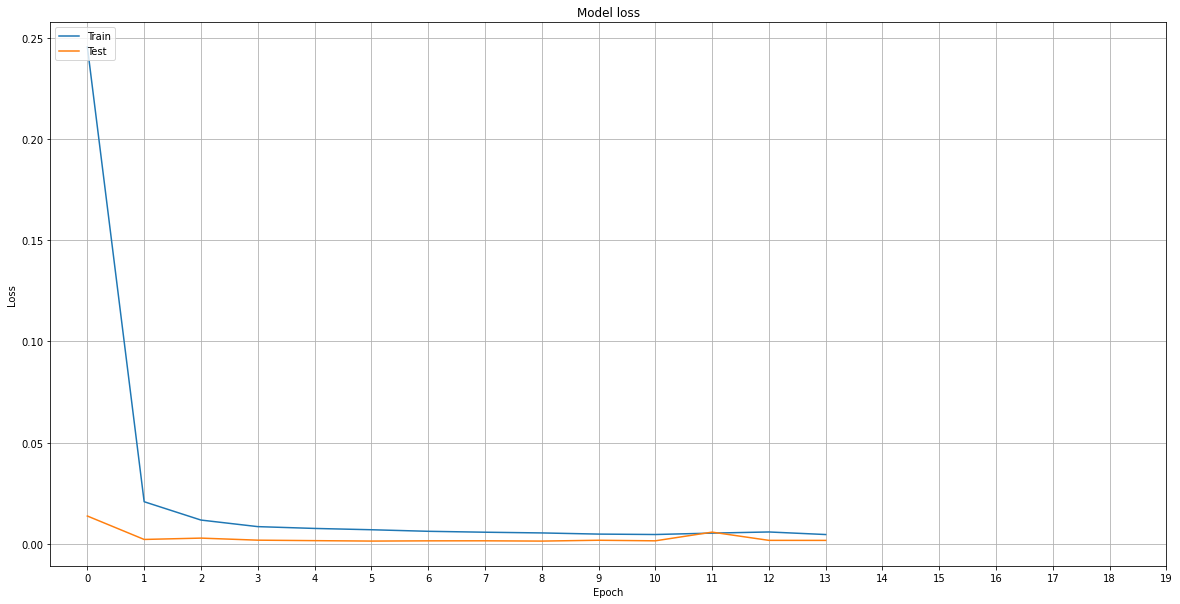

In [11]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [12]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list
results

Median Absolute Error (MAE): 0.52
Mean Absolute Percentage Error (MAPE): 5.04 %
Median Absolute Percentage Error (MDAPE): 4.49 %


,MAE,MAPE,MDAPE
0,0.519107,5.03598,4.48548


In [13]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

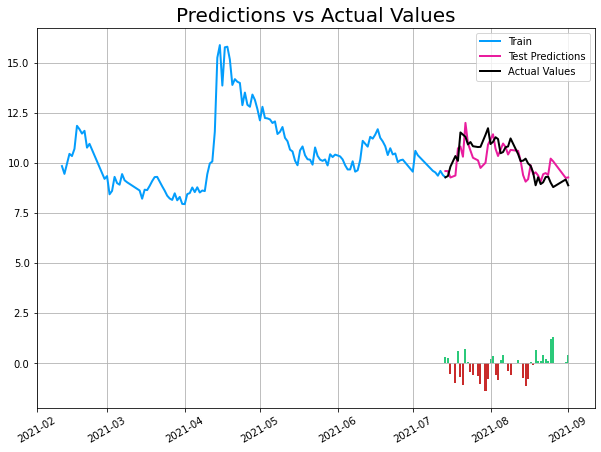

In [14]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

### 4-Day Shift

In [15]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 4

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['2Dir', 'Daily%Change', '6Dir', 'Open', 'Low', '7D%Change', '5D%Change', '2D%Change', 'SD', '4D%Change', '3D%Change', 'Volume', '4Dir', '6D%Change', 'SD_log', 'High', 'Dir', '5Dir', '7Dir', '3Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-4),comments_positive(t-4),comment_count(t-4),pct_pos_comments(t-4),comments_neutral_rollsum_2D(t-4),comments_neutral_rollmean_2D(t-4),comments_neutral_2D_pctchg(t-4),comments_positive_rollsum_2D(t-4),...,Volume(t-4),4Dir(t-4),6D%Change(t-4),SD_log(t-4),High(t-4),Dir(t-4),5Dir(t-4),7Dir(t-4),3Dir(t-4),Close(t-4)
10,12.350000,1,2497.0,2118.0,4615.0,45.893823,3295.0,1647.5,2737.500000,3093.0,...,9416000.0,1.0,15.957450,-0.834819,7.71,0.0,1.0,1.0,1.0,7.63
11,12.790000,2,1078.0,923.0,2001.0,46.126934,3575.0,1787.5,35.087719,3041.0,...,8345500.0,1.0,9.896604,-0.673449,7.66,0.0,1.0,1.0,0.0,7.44
12,12.850000,3,530.0,331.0,861.0,38.443666,1608.0,804.0,-78.774529,1254.0,...,65231300.0,1.0,35.767505,1.446863,9.33,1.0,1.0,1.0,1.0,9.11
13,14.040000,4,816.0,497.0,1313.0,37.852244,1346.0,673.0,-24.304267,828.0,...,153854700.0,1.0,39.376774,1.927521,11.56,1.0,1.0,1.0,1.0,9.84
14,18.030001,0,1069.0,845.0,1914.0,44.148378,2025.0,1012.5,-33.103880,1557.0,...,112483200.0,1.0,63.359795,1.448698,12.39,1.0,1.0,1.0,1.0,12.35


In [16]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-4)', 'comments_positive(t-4)', 'comment_count(t-4)', 'pct_pos_comments(t-4)', 'comments_neutral_rollsum_2D(t-4)', 'comments_neutral_rollmean_2D(t-4)', 'comments_neutral_2D_pctchg(t-4)', 'comments_positive_rollsum_2D(t-4)', 'comments_positive_rollmean_2D(t-4)', 'comments_positive_2D_pctchg(t-4)', 'comment_count_rollsum_2D(t-4)', 'comment_count_rollmean_2D(t-4)', 'comment_count_2D_pctchg(t-4)', 'pct_pos_comments_rollsum_2D(t-4)', 'pct_pos_comments_rollmean_2D(t-4)', 'pct_pos_comments_2D_pctchg(t-4)', 'comments_neutral_rollsum_3D(t-4)', 'comments_neutral_rollmean_3D(t-4)', 'comments_neutral_3D_pctchg(t-4)', 'comments_positive_rollsum_3D(t-4)', 'comments_positive_rollmean_3D(t-4)', 'comments_positive_3D_pctchg(t-4)', 'comment_count_rollsum_3D(t-4)', 'comment_count_rollmean_3D(t-4)', 'comment_count_3D_pctchg(t-4)', 'pct_pos_comments_rollsum_3D(t-4)', 'pct_pos_comments_rollmean_3D(t-4)', 'pct_pos_comments_3D_pctchg(t-4)', 'comments_ne

,Close,day_of_week,comments_neutral(t-4),comments_positive(t-4),comment_count(t-4),pct_pos_comments(t-4),comments_neutral_rollsum_2D(t-4),comments_neutral_rollmean_2D(t-4),comments_neutral_2D_pctchg(t-4),comments_positive_rollsum_2D(t-4),...,Volume(t-4),4Dir(t-4),6D%Change(t-4),SD_log(t-4),High(t-4),Dir(t-4),5Dir(t-4),7Dir(t-4),3Dir(t-4),Close(t-4)
239,8.60,1,4.0,0.0,4.0,0.000000,11.0,5.5,-66.666667,1.0,...,6044800.0,1.0,-2.205883,-0.403923,9.47,1.0,1.0,0.0,1.0,9.31
240,8.93,2,0.0,0.0,0.0,0.000000,4.0,2.0,-100.000000,0.0,...,4532500.0,1.0,1.463965,-0.417755,9.33,0.0,0.0,0.0,0.0,9.01
243,8.88,0,2.0,3.0,5.0,59.998800,4.0,2.0,100.000000,3.0,...,8079400.0,0.0,-4.761898,0.015579,8.81,0.0,0.0,0.0,0.0,8.60
245,9.41,2,1.0,2.0,3.0,66.664445,3.0,1.5,-50.000000,2.0,...,8521800.0,0.0,-5.692811,0.424416,9.19,0.0,0.0,0.0,1.0,8.78
246,9.48,3,3.0,1.0,4.0,24.999375,4.0,2.0,50.000000,3.0,...,13789600.0,1.0,1.775803,0.517488,9.30,1.0,1.0,0.0,1.0,9.17


In [17]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(167, 100)
(48, 100)


In [18]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(160, 7, 99) (160,)
(41, 7, 99) (41,)
0.75
0.3910256080722637


In [19]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

693 7 99


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.4016
Epoch 1: val_loss improved from inf to 0.01316, saving model to BB_Close_4shift_Sentiment.h5
10/10 [==============================] - 7s 449ms/step - loss: 0.4016 - val_loss: 0.0132
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0157
Epoch 2: val_loss improved from 0.01316 to 0.00266, saving model to BB_Close_4shift_Sentiment.h5
10/10 [==============================] - 3s 314ms/step - loss: 0.0157 - val_loss: 0.0027
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0070
Epoch 3: val_loss did not improve from 0.00266
10/10 [==============================] - 3s 299ms/step - loss: 0.0070 - val_loss: 0.0038
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0049
Epoch 4: val_loss improved from 0.00266 to 0.00229, saving model to BB_Close_4shift_Sentiment.h5
10/10 [==============================] - 3s 318ms/step - loss: 0.0049 - val_loss: 0.0023
Epoch 

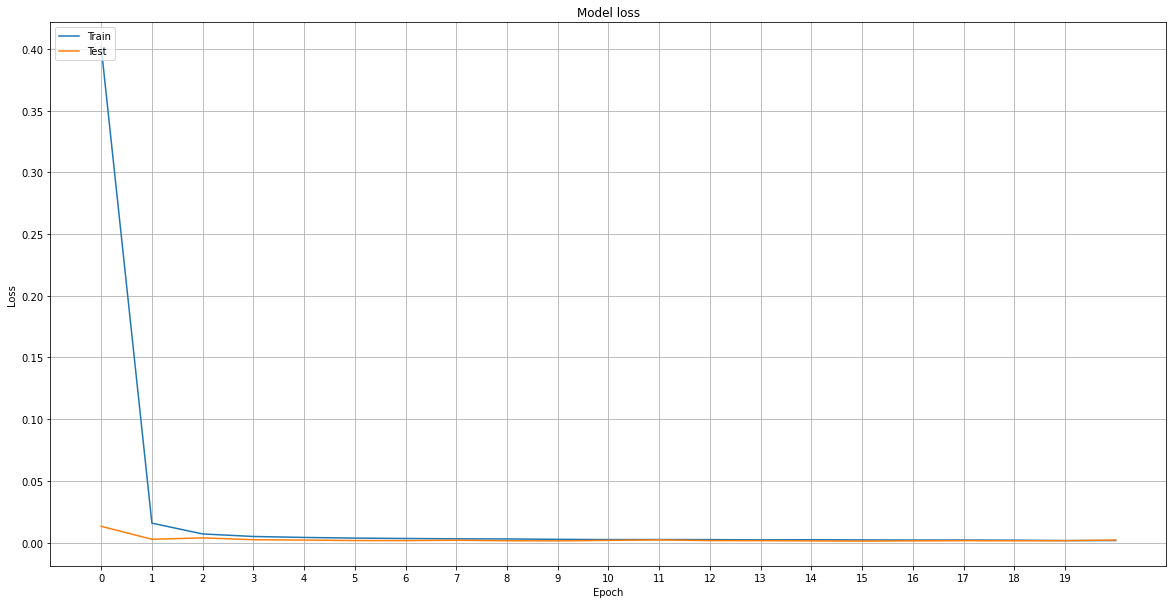

In [21]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 0.49
Mean Absolute Percentage Error (MAPE): 4.91 %
Median Absolute Percentage Error (MDAPE): 4.31 %


,MAE,MAPE,MDAPE
0,0.491548,4.912796,4.30907


In [23]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

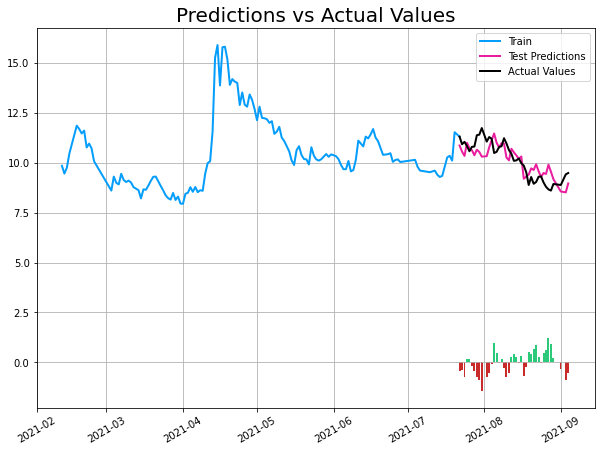

In [24]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

### 7-Day Shift

In [25]:
## DAILY%CHANGE ##
dep_var = ['Close'] 
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 7

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['2Dir', 'Daily%Change', '6Dir', 'Open', 'Low', '7D%Change', '5D%Change', '2D%Change', 'SD', '4D%Change', '3D%Change', 'Volume', '4Dir', '6D%Change', 'SD_log', 'High', 'Dir', '5Dir', '7Dir', '3Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-7),comments_positive(t-7),comment_count(t-7),pct_pos_comments(t-7),comments_neutral_rollsum_2D(t-7),comments_neutral_rollmean_2D(t-7),comments_neutral_2D_pctchg(t-7),comments_positive_rollsum_2D(t-7),...,Volume(t-7),4Dir(t-7),6D%Change(t-7),SD_log(t-7),High(t-7),Dir(t-7),5Dir(t-7),7Dir(t-7),3Dir(t-7),Close(t-7)
13,14.040000,4,2497.0,2118.0,4615.0,45.893823,3295.0,1647.5,2737.500000,3093.0,...,9416000.0,1.0,15.957450,-0.834819,7.71,0.0,1.0,1.0,1.0,7.63
14,18.030001,0,816.0,497.0,1313.0,37.852244,1346.0,673.0,-24.304267,828.0,...,8345500.0,1.0,9.896604,-0.673449,7.66,0.0,1.0,1.0,0.0,7.44
15,18.920000,1,1598.0,1237.0,2835.0,43.633155,2414.0,1207.0,201.509434,1734.0,...,65231300.0,1.0,35.767505,1.446863,9.33,1.0,1.0,1.0,1.0,9.11
16,25.100000,2,956.0,712.0,1668.0,42.685849,2554.0,1277.0,17.156863,1949.0,...,153854700.0,1.0,39.376774,1.927521,11.56,1.0,1.0,1.0,1.0,9.84
17,14.650000,3,1069.0,845.0,1914.0,44.148378,2025.0,1012.5,-33.103880,1557.0,...,112483200.0,1.0,63.359795,1.448698,12.39,1.0,1.0,1.0,1.0,12.35


In [26]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-7)', 'comments_positive(t-7)', 'comment_count(t-7)', 'pct_pos_comments(t-7)', 'comments_neutral_rollsum_2D(t-7)', 'comments_neutral_rollmean_2D(t-7)', 'comments_neutral_2D_pctchg(t-7)', 'comments_positive_rollsum_2D(t-7)', 'comments_positive_rollmean_2D(t-7)', 'comments_positive_2D_pctchg(t-7)', 'comment_count_rollsum_2D(t-7)', 'comment_count_rollmean_2D(t-7)', 'comment_count_2D_pctchg(t-7)', 'pct_pos_comments_rollsum_2D(t-7)', 'pct_pos_comments_rollmean_2D(t-7)', 'pct_pos_comments_2D_pctchg(t-7)', 'comments_neutral_rollsum_3D(t-7)', 'comments_neutral_rollmean_3D(t-7)', 'comments_neutral_3D_pctchg(t-7)', 'comments_positive_rollsum_3D(t-7)', 'comments_positive_rollmean_3D(t-7)', 'comments_positive_3D_pctchg(t-7)', 'comment_count_rollsum_3D(t-7)', 'comment_count_rollmean_3D(t-7)', 'comment_count_3D_pctchg(t-7)', 'pct_pos_comments_rollsum_3D(t-7)', 'pct_pos_comments_rollmean_3D(t-7)', 'pct_pos_comments_3D_pctchg(t-7)', 'comments_ne

,Close,day_of_week,comments_neutral(t-7),comments_positive(t-7),comment_count(t-7),pct_pos_comments(t-7),comments_neutral_rollsum_2D(t-7),comments_neutral_rollmean_2D(t-7),comments_neutral_2D_pctchg(t-7),comments_positive_rollsum_2D(t-7),...,Volume(t-7),4Dir(t-7),6D%Change(t-7),SD_log(t-7),High(t-7),Dir(t-7),5Dir(t-7),7Dir(t-7),3Dir(t-7),Close(t-7)
239,8.60,1,94.0,48.0,142.0,33.802793,166.0,83.0,2250.000000,77.0,...,12810300.0,0.0,-12.438790,0.279937,9.39,0.0,0.0,0.0,0.0,8.94
240,8.93,2,12.0,4.0,16.0,24.999844,106.0,53.0,-83.333333,52.0,...,6232300.0,0.0,-9.428290,-0.368117,9.10,1.0,0.0,0.0,1.0,9.03
241,8.78,3,7.0,1.0,8.0,12.499844,19.0,9.5,-92.553191,5.0,...,6331600.0,1.0,-5.685283,0.479275,9.49,1.0,0.0,0.0,1.0,9.29
242,9.17,4,4.0,0.0,4.0,0.000000,11.0,5.5,-66.666667,1.0,...,6044800.0,1.0,-2.205883,-0.403923,9.47,1.0,1.0,0.0,1.0,9.31
246,9.48,3,2.0,3.0,5.0,59.998800,4.0,2.0,100.000000,3.0,...,8079400.0,0.0,-4.761898,0.015579,8.81,0.0,0.0,0.0,0.0,8.60


In [27]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)



(168, 100)
(49, 100)


In [28]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(161, 7, 99) (161,)
(42, 7, 99) (42,)
0.25
0.21037296417838725


In [29]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

693 7 99


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Sentiment.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.6081
Epoch 1: val_loss improved from inf to 0.00358, saving model to BB_Close_7shift_Sentiment.h5
11/11 [==============================] - 8s 410ms/step - loss: 0.6081 - val_loss: 0.0036
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 0.0202
Epoch 2: val_loss did not improve from 0.00358
11/11 [==============================] - 3s 290ms/step - loss: 0.0202 - val_loss: 0.0039
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 0.0099
Epoch 3: val_loss did not improve from 0.00358
11/11 [==============================] - 3s 287ms/step - loss: 0.0099 - val_loss: 0.0043
Epoch 4/100
11/11 [==============================] - ETA: 0s - loss: 0.0085
Epoch 4: val_loss improved from 0.00358 to 0.00292, saving model to BB_Close_7shift_Sentiment.h5
11/11 [==============================] - 3s 316ms/step - loss: 0.0085 - val_loss: 0.0029
Epoch 5/100
11/11 [==============================] - ETA

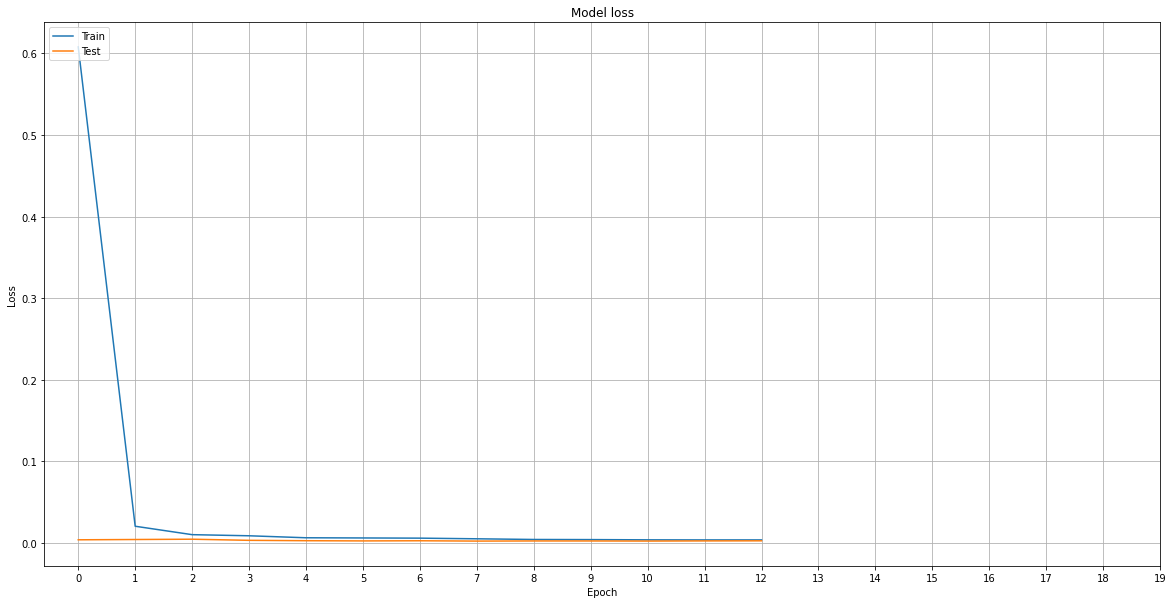

In [31]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 0.6
Mean Absolute Percentage Error (MAPE): 5.95 %
Median Absolute Percentage Error (MDAPE): 3.82 %


,MAE,MAPE,MDAPE
0,0.601907,5.952361,3.817238


In [33]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

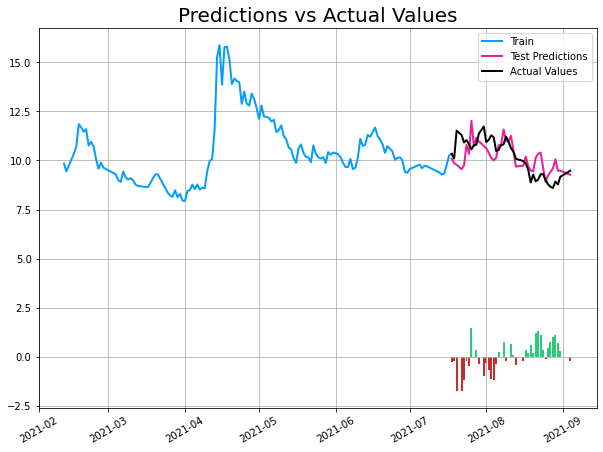

In [34]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

## LSTM: CLOSE PRICE WITHOUT SENTIMENT

### 1-Day Shift

In [35]:
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['2Dir', 'Daily%Change', '6Dir', 'Open', 'Low', '7D%Change', '5D%Change', '2D%Change', 'SD', '4D%Change', '3D%Change', 'Volume', '4Dir', '6D%Change', 'SD_log', 'High', 'Dir', '5Dir', '7Dir', '3Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-1),comment_count_rollsum_2D(t-1),comment_count_rollmean_2D(t-1),comment_count_2D_pctchg(t-1),comment_count_rollsum_3D(t-1),comment_count_rollmean_3D(t-1),comment_count_3D_pctchg(t-1),comment_count_rollsum_4D(t-1),...,Volume(t-1),4Dir(t-1),6D%Change(t-1),SD_log(t-1),High(t-1),Dir(t-1),5Dir(t-1),7Dir(t-1),3Dir(t-1),Close(t-1)
7,7.44,2,733.0,1713.0,856.5,877.333333,1788.0,596.000000,1337.254902,1839.0,...,9416000.0,1.0,15.957450,-0.834819,7.71,0.0,1.0,1.0,1.0,7.63
8,9.11,3,113.0,846.0,423.0,-88.469388,1826.0,608.666667,50.666667,1901.0,...,8345500.0,1.0,9.896604,-0.673449,7.66,0.0,1.0,1.0,0.0,7.44
9,9.84,4,1773.0,1886.0,943.0,141.882674,2619.0,873.000000,80.918367,3599.0,...,65231300.0,1.0,35.767505,1.446863,9.33,1.0,1.0,1.0,1.0,9.11
10,12.35,1,1313.0,2174.0,1087.0,-34.382809,4175.0,1391.666667,-71.549296,8790.0,...,153854700.0,1.0,39.376774,1.927521,11.56,1.0,1.0,1.0,1.0,9.84
11,12.79,2,2835.0,4148.0,2074.0,229.268293,5009.0,1669.666667,41.679160,7010.0,...,112483200.0,1.0,63.359795,1.448698,12.39,1.0,1.0,1.0,1.0,12.35


In [36]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()


FEATURE LIST
['Close', 'day_of_week', 'comment_count(t-1)', 'comment_count_rollsum_2D(t-1)', 'comment_count_rollmean_2D(t-1)', 'comment_count_2D_pctchg(t-1)', 'comment_count_rollsum_3D(t-1)', 'comment_count_rollmean_3D(t-1)', 'comment_count_3D_pctchg(t-1)', 'comment_count_rollsum_4D(t-1)', 'comment_count_rollmean_4D(t-1)', 'comment_count_4D_pctchg(t-1)', 'comment_count_rollsum_5D(t-1)', 'comment_count_rollmean_5D(t-1)', 'comment_count_5D_pctchg(t-1)', 'comment_count_rollsum_6D(t-1)', 'comment_count_rollmean_6D(t-1)', 'comment_count_6D_pctchg(t-1)', 'comment_count_rollsum_7D(t-1)', 'comment_count_rollmean_7D(t-1)', 'comment_count_7D_pctchg(t-1)', 'is_meme(t-1)', '2Dir(t-1)', 'Daily%Change(t-1)', '6Dir(t-1)', 'Open(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5D%Change(t-1)', '2D%Change(t-1)', 'SD(t-1)', '4D%Change(t-1)', '3D%Change(t-1)', 'Volume(t-1)', '4Dir(t-1)', '6D%Change(t-1)', 'SD_log(t-1)', 'High(t-1)', 'Dir(t-1)', '5Dir(t-1)', '7Dir(t-1)', '3Dir(t-1)', 'Close(t-1)']


,Close,day_of_week,comment_count(t-1),comment_count_rollsum_2D(t-1),comment_count_rollmean_2D(t-1),comment_count_2D_pctchg(t-1),comment_count_rollsum_3D(t-1),comment_count_rollmean_3D(t-1),comment_count_3D_pctchg(t-1),comment_count_rollsum_4D(t-1),...,Volume(t-1),4Dir(t-1),6D%Change(t-1),SD_log(t-1),High(t-1),Dir(t-1),5Dir(t-1),7Dir(t-1),3Dir(t-1),Close(t-1)
241,8.78,3,2.0,2.0,1.0,100.0,3.0,1.000000,100.000000,3.0,...,15904400.0,0.0,-3.875131,0.574118,9.07,1.0,0.0,0.0,1.0,8.93
242,9.17,4,5.0,7.0,3.5,100.0,7.0,2.333333,400.000000,8.0,...,8521800.0,0.0,-5.692811,0.424416,9.19,0.0,0.0,0.0,1.0,8.78
243,8.88,0,4.0,7.0,3.5,100.0,9.0,3.000000,-20.000000,14.0,...,13789600.0,1.0,1.775803,0.517488,9.30,1.0,1.0,0.0,1.0,9.17
245,9.41,2,2.0,2.0,1.0,-50.0,6.0,2.000000,-33.333333,9.0,...,15025300.0,1.0,6.812935,0.446533,9.41,1.0,1.0,1.0,1.0,9.25
246,9.48,3,1.0,3.0,1.5,100.0,3.0,1.000000,-75.000000,7.0,...,20581000.0,1.0,9.418598,0.910949,9.49,1.0,1.0,1.0,1.0,9.41


In [37]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(183, 43)
(52, 43)


In [38]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(176, 7, 42) (176,)
(45, 7, 42) (45,)
0.0
0.5996602737817465


In [39]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

294 7 42


In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.0871
Epoch 1: val_loss improved from inf to 0.01170, saving model to BB_Close_1shift_Baseline.h5
11/11 [==============================] - 5s 171ms/step - loss: 0.0871 - val_loss: 0.0117
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 0.0146
Epoch 2: val_loss improved from 0.01170 to 0.00224, saving model to BB_Close_1shift_Baseline.h5
11/11 [==============================] - 1s 75ms/step - loss: 0.0146 - val_loss: 0.0022
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 0.0088
Epoch 3: val_loss did not improve from 0.00224
11/11 [==============================] - 1s 66ms/step - loss: 0.0088 - val_loss: 0.0027
Epoch 4/100
11/11 [==============================] - ETA: 0s - loss: 0.0068
Epoch 4: val_loss did not improve from 0.00224
11/11 [==============================] - 1s 65ms/step - loss: 0.0068 - val_loss: 0.0028
Epoch 5/100
11/11 [==============================] - ETA: 0s 

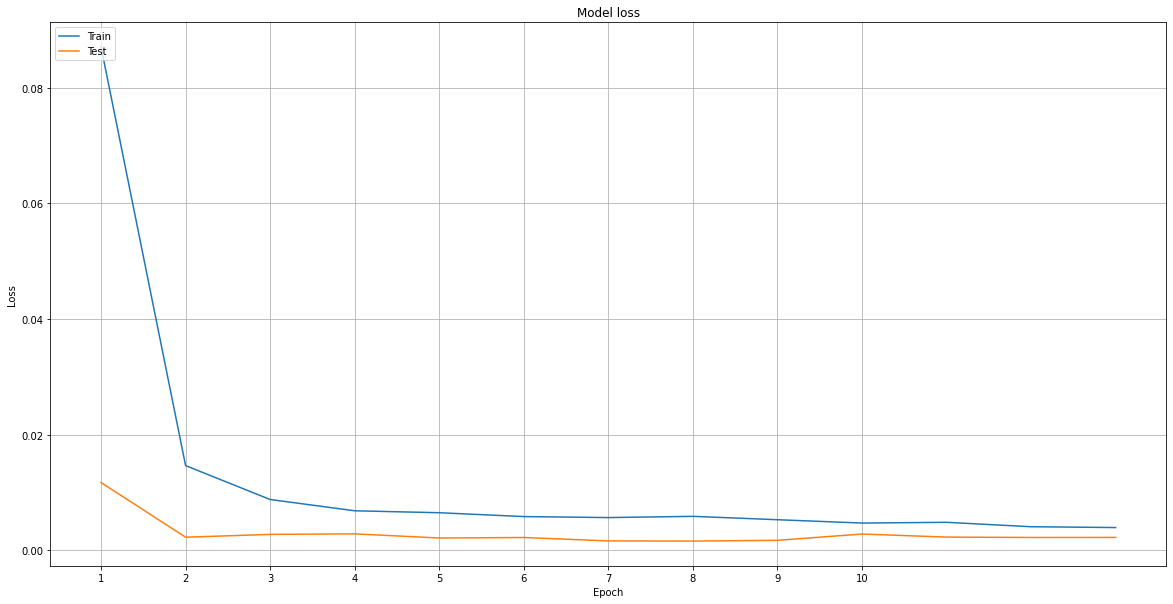

In [41]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [42]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list


results

Median Absolute Error (MAE): 0.52
Mean Absolute Percentage Error (MAPE): 5.1 %
Median Absolute Percentage Error (MDAPE): 2.65 %


,MAE,MAPE,MDAPE
0,0.521468,5.104635,2.652216


In [43]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

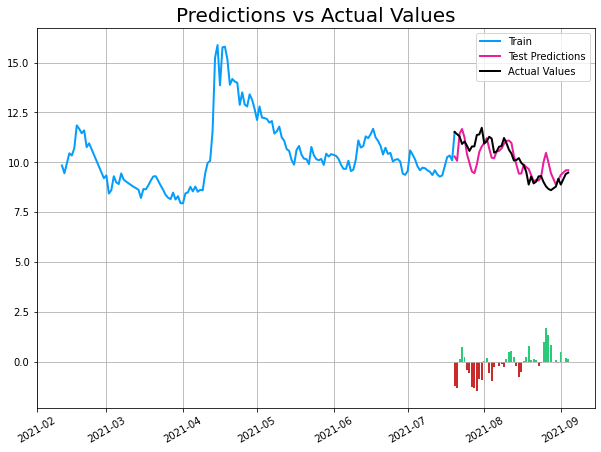

In [44]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

### 4-Day Shift

In [45]:
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 4

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['2Dir', 'Daily%Change', '6Dir', 'Open', 'Low', '7D%Change', '5D%Change', '2D%Change', 'SD', '4D%Change', '3D%Change', 'Volume', '4Dir', '6D%Change', 'SD_log', 'High', 'Dir', '5Dir', '7Dir', '3Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-4),comment_count_rollsum_2D(t-4),comment_count_rollmean_2D(t-4),comment_count_2D_pctchg(t-4),comment_count_rollsum_3D(t-4),comment_count_rollmean_3D(t-4),comment_count_3D_pctchg(t-4),comment_count_rollsum_4D(t-4),...,Volume(t-4),4Dir(t-4),6D%Change(t-4),SD_log(t-4),High(t-4),Dir(t-4),5Dir(t-4),7Dir(t-4),3Dir(t-4),Close(t-4)
10,12.350000,1,4615.0,6388.0,3194.0,3984.070796,6501.0,2167.000000,529.604366,7234.0,...,9416000.0,1.0,15.957450,-0.834819,7.71,0.0,1.0,1.0,1.0,7.63
11,12.790000,2,2001.0,6616.0,3308.0,12.859560,8389.0,2796.333333,1670.796460,8502.0,...,8345500.0,1.0,9.896604,-0.673449,7.66,0.0,1.0,1.0,0.0,7.44
12,12.850000,3,861.0,2862.0,1431.0,-81.343445,7477.0,2492.333333,-51.438240,9250.0,...,65231300.0,1.0,35.767505,1.446863,9.33,1.0,1.0,1.0,1.0,9.11
13,14.040000,4,1313.0,2174.0,1087.0,-34.382809,4175.0,1391.666667,-71.549296,8790.0,...,153854700.0,1.0,39.376774,1.927521,11.56,1.0,1.0,1.0,1.0,9.84
14,18.030001,0,1914.0,3582.0,1791.0,-32.486772,6417.0,2139.000000,45.773039,7730.0,...,112483200.0,1.0,63.359795,1.448698,12.39,1.0,1.0,1.0,1.0,12.35


In [46]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comment_count(t-4)', 'comment_count_rollsum_2D(t-4)', 'comment_count_rollmean_2D(t-4)', 'comment_count_2D_pctchg(t-4)', 'comment_count_rollsum_3D(t-4)', 'comment_count_rollmean_3D(t-4)', 'comment_count_3D_pctchg(t-4)', 'comment_count_rollsum_4D(t-4)', 'comment_count_rollmean_4D(t-4)', 'comment_count_4D_pctchg(t-4)', 'comment_count_rollsum_5D(t-4)', 'comment_count_rollmean_5D(t-4)', 'comment_count_5D_pctchg(t-4)', 'comment_count_rollsum_6D(t-4)', 'comment_count_rollmean_6D(t-4)', 'comment_count_6D_pctchg(t-4)', 'comment_count_rollsum_7D(t-4)', 'comment_count_rollmean_7D(t-4)', 'comment_count_7D_pctchg(t-4)', 'is_meme(t-4)', '2Dir(t-4)', 'Daily%Change(t-4)', '6Dir(t-4)', 'Open(t-4)', 'Low(t-4)', '7D%Change(t-4)', '5D%Change(t-4)', '2D%Change(t-4)', 'SD(t-4)', '4D%Change(t-4)', '3D%Change(t-4)', 'Volume(t-4)', '4Dir(t-4)', '6D%Change(t-4)', 'SD_log(t-4)', 'High(t-4)', 'Dir(t-4)', '5Dir(t-4)', '7Dir(t-4)', '3Dir(t-4)', 'Close(t-4)']


,Close,day_of_week,comment_count(t-4),comment_count_rollsum_2D(t-4),comment_count_rollmean_2D(t-4),comment_count_2D_pctchg(t-4),comment_count_rollsum_3D(t-4),comment_count_rollmean_3D(t-4),comment_count_3D_pctchg(t-4),comment_count_rollsum_4D(t-4),...,Volume(t-4),4Dir(t-4),6D%Change(t-4),SD_log(t-4),High(t-4),Dir(t-4),5Dir(t-4),7Dir(t-4),3Dir(t-4),Close(t-4)
243,8.88,0,5.0,7.0,3.5,100.0,7.0,2.333333,400.0,8.0,...,8079400.0,0.0,-4.761898,0.015579,8.81,0.0,0.0,0.0,0.0,8.60
244,9.25,1,2.0,7.0,3.5,0.0,9.0,3.000000,100.0,9.0,...,15904400.0,0.0,-3.875131,0.574118,9.07,1.0,0.0,0.0,1.0,8.93
245,9.41,2,3.0,5.0,2.5,-40.0,10.0,3.333333,50.0,12.0,...,8521800.0,0.0,-5.692811,0.424416,9.19,0.0,0.0,0.0,1.0,8.78
246,9.48,3,4.0,7.0,3.5,100.0,9.0,3.000000,-20.0,14.0,...,13789600.0,1.0,1.775803,0.517488,9.30,1.0,1.0,0.0,1.0,9.17
249,9.21,2,1.0,1.0,0.5,100.0,1.0,0.333333,0.0,2.0,...,20581000.0,1.0,9.418598,0.910949,9.49,1.0,1.0,1.0,1.0,9.41


In [47]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(181, 43)
(52, 43)


In [48]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(174, 7, 42) (174,)
(45, 7, 42) (45,)
0.75
0.3910256080722637


In [49]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

294 7 42


In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.0653
Epoch 1: val_loss improved from inf to 0.01231, saving model to BB_Close_4shift_Baseline.h5
11/11 [==============================] - 6s 165ms/step - loss: 0.0653 - val_loss: 0.0123
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 0.0093
Epoch 2: val_loss improved from 0.01231 to 0.00141, saving model to BB_Close_4shift_Baseline.h5
11/11 [==============================] - 1s 78ms/step - loss: 0.0093 - val_loss: 0.0014
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 0.0056
Epoch 3: val_loss did not improve from 0.00141
11/11 [==============================] - 1s 67ms/step - loss: 0.0056 - val_loss: 0.0017
Epoch 4/100
11/11 [==============================] - ETA: 0s - loss: 0.0045
Epoch 4: val_loss did not improve from 0.00141
11/11 [==============================] - 1s 69ms/step - loss: 0.0045 - val_loss: 0.0017
Epoch 5/100
11/11 [==============================] - ETA: 0s 

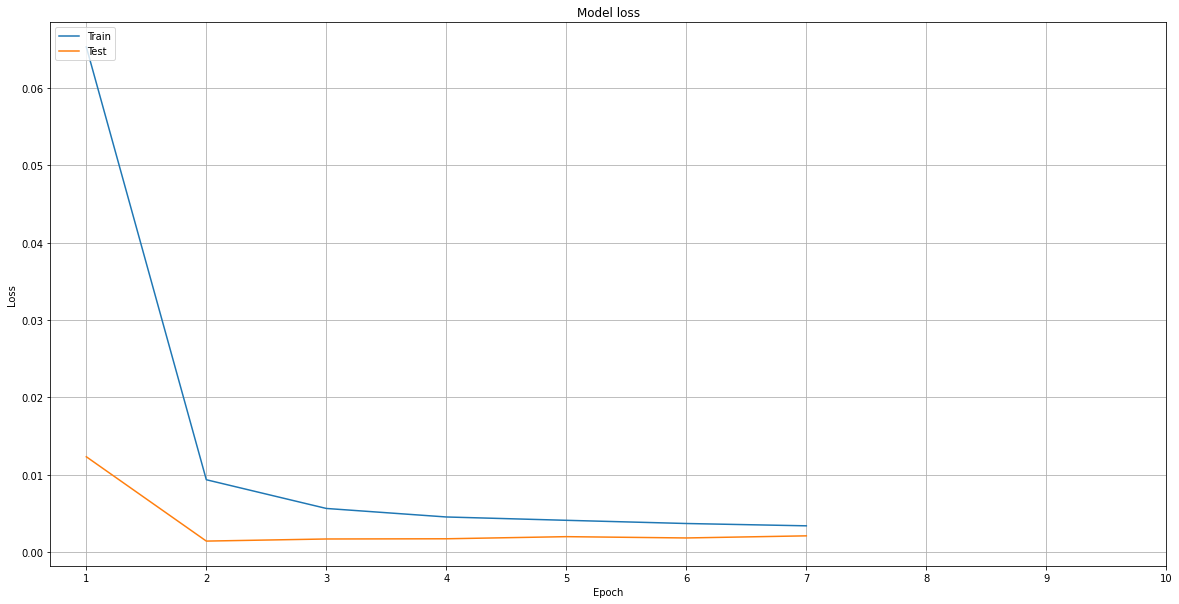

In [51]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [52]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list


results

Median Absolute Error (MAE): 0.55
Mean Absolute Percentage Error (MAPE): 5.76 %
Median Absolute Percentage Error (MDAPE): 5.2 %


,MAE,MAPE,MDAPE
0,0.554662,5.760614,5.20117


In [53]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

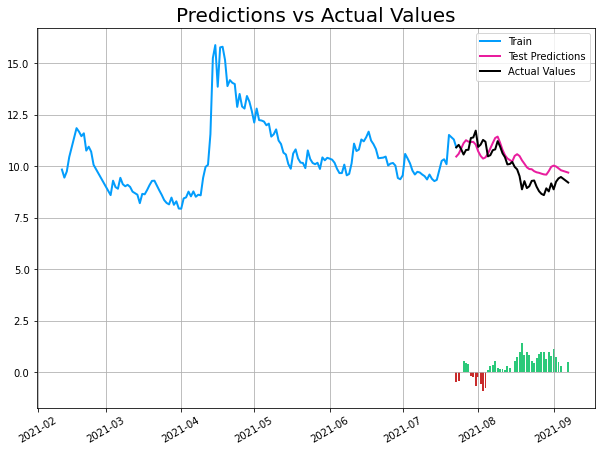

In [54]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

### 7-Day Shift

In [55]:
bdep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 7

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

to_drop = [i for i in pred_lag.columns if 'pos' in i] + [i for i in pred_lag.columns if 'neu' in i]
pred_lag = pred_lag.drop(to_drop, axis = 1)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['2Dir', 'Daily%Change', '6Dir', 'Open', 'Low', '7D%Change', '5D%Change', '2D%Change', 'SD', '4D%Change', '3D%Change', 'Volume', '4Dir', '6D%Change', 'SD_log', 'High', 'Dir', '5Dir', '7Dir', '3Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comment_count(t-7),comment_count_rollsum_2D(t-7),comment_count_rollmean_2D(t-7),comment_count_2D_pctchg(t-7),comment_count_rollsum_3D(t-7),comment_count_rollmean_3D(t-7),comment_count_3D_pctchg(t-7),comment_count_rollsum_4D(t-7),...,Volume(t-7),4Dir(t-7),6D%Change(t-7),SD_log(t-7),High(t-7),Dir(t-7),5Dir(t-7),7Dir(t-7),3Dir(t-7),Close(t-7)
13,14.040000,4,4615.0,6388.0,3194.0,3984.070796,6501.0,2167.000000,529.604366,7234.0,...,9416000.0,1.0,15.957450,-0.834819,7.71,0.0,1.0,1.0,1.0,7.63
14,18.030001,0,1313.0,2174.0,1087.0,-34.382809,4175.0,1391.666667,-71.549296,8790.0,...,8345500.0,1.0,9.896604,-0.673449,7.66,0.0,1.0,1.0,0.0,7.44
15,18.920000,1,2835.0,4148.0,2074.0,229.268293,5009.0,1669.666667,41.679160,7010.0,...,65231300.0,1.0,35.767505,1.446863,9.33,1.0,1.0,1.0,1.0,9.11
16,25.100000,2,1668.0,4503.0,2251.5,27.037319,5816.0,1938.666667,93.728223,6677.0,...,153854700.0,1.0,39.376774,1.927521,11.56,1.0,1.0,1.0,1.0,9.84
17,14.650000,3,1914.0,3582.0,1791.0,-32.486772,6417.0,2139.000000,45.773039,7730.0,...,112483200.0,1.0,63.359795,1.448698,12.39,1.0,1.0,1.0,1.0,12.35


In [56]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
# data_filtered_ext['Prediction'] = data_filtered_ext[dep_var[0]]
#data_filtered_ext.drop(dep_var, axis = 1, inplace = True)

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comment_count(t-7)', 'comment_count_rollsum_2D(t-7)', 'comment_count_rollmean_2D(t-7)', 'comment_count_2D_pctchg(t-7)', 'comment_count_rollsum_3D(t-7)', 'comment_count_rollmean_3D(t-7)', 'comment_count_3D_pctchg(t-7)', 'comment_count_rollsum_4D(t-7)', 'comment_count_rollmean_4D(t-7)', 'comment_count_4D_pctchg(t-7)', 'comment_count_rollsum_5D(t-7)', 'comment_count_rollmean_5D(t-7)', 'comment_count_5D_pctchg(t-7)', 'comment_count_rollsum_6D(t-7)', 'comment_count_rollmean_6D(t-7)', 'comment_count_6D_pctchg(t-7)', 'comment_count_rollsum_7D(t-7)', 'comment_count_rollmean_7D(t-7)', 'comment_count_7D_pctchg(t-7)', 'is_meme(t-7)', '2Dir(t-7)', 'Daily%Change(t-7)', '6Dir(t-7)', 'Open(t-7)', 'Low(t-7)', '7D%Change(t-7)', '5D%Change(t-7)', '2D%Change(t-7)', 'SD(t-7)', '4D%Change(t-7)', '3D%Change(t-7)', 'Volume(t-7)', '4Dir(t-7)', '6D%Change(t-7)', 'SD_log(t-7)', 'High(t-7)', 'Dir(t-7)', '5Dir(t-7)', '7Dir(t-7)', '3Dir(t-7)', 'Close(t-7)']


,Close,day_of_week,comment_count(t-7),comment_count_rollsum_2D(t-7),comment_count_rollmean_2D(t-7),comment_count_2D_pctchg(t-7),comment_count_rollsum_3D(t-7),comment_count_rollmean_3D(t-7),comment_count_3D_pctchg(t-7),comment_count_rollsum_4D(t-7),...,Volume(t-7),4Dir(t-7),6D%Change(t-7),SD_log(t-7),High(t-7),Dir(t-7),5Dir(t-7),7Dir(t-7),3Dir(t-7),Close(t-7)
243,8.88,0,1.0,1.0,0.5,100.0,1.0,0.333333,-75.000000,5.0,...,4532500.0,1.0,1.463965,-0.417755,9.33,0.0,0.0,0.0,0.0,9.01
245,9.41,2,2.0,2.0,1.0,100.0,3.0,1.000000,100.000000,3.0,...,7882500.0,0.0,-3.131988,-0.192288,9.01,0.0,0.0,0.0,0.0,8.66
246,9.48,3,5.0,7.0,3.5,100.0,7.0,2.333333,400.000000,8.0,...,8079400.0,0.0,-4.761898,0.015579,8.81,0.0,0.0,0.0,0.0,8.60
248,9.44,1,2.0,2.0,1.0,-50.0,6.0,2.000000,-33.333333,9.0,...,8521800.0,0.0,-5.692811,0.424416,9.19,0.0,0.0,0.0,1.0,8.78
249,9.21,2,1.0,3.0,1.5,100.0,3.0,1.000000,-75.000000,7.0,...,13789600.0,1.0,1.775803,0.517488,9.30,1.0,1.0,0.0,1.0,9.17


In [57]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc(dep_var[0])

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len] # DATA_FILTERED USED FOR PREDICTION
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext[dep_var[0]][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(183, 43)
(52, 43)


In [58]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,1:data.shape[1]+1]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])


(176, 7, 42) (176,)
(45, 7, 42) (45,)
0.25
0.21037296417838725


In [59]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

294 7 42


In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = '{}_{}_{}shift_Baseline.h5'.format(ticker, dep_var[0], shift)
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
11/11 [==============================] - ETA: 0s - loss: 0.0439
Epoch 1: val_loss improved from inf to 0.01009, saving model to BB_Close_7shift_Baseline.h5
11/11 [==============================] - 5s 218ms/step - loss: 0.0439 - val_loss: 0.0101
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 0.0088
Epoch 2: val_loss improved from 0.01009 to 0.00142, saving model to BB_Close_7shift_Baseline.h5
11/11 [==============================] - 1s 72ms/step - loss: 0.0088 - val_loss: 0.0014
Epoch 3/100
11/11 [==============================] - ETA: 0s - loss: 0.0062
Epoch 3: val_loss did not improve from 0.00142
11/11 [==============================] - 1s 64ms/step - loss: 0.0062 - val_loss: 0.0019
Epoch 4/100
11/11 [==============================] - ETA: 0s - loss: 0.0055
Epoch 4: val_loss did not improve from 0.00142
11/11 [==============================] - 1s 67ms/step - loss: 0.0055 - val_loss: 0.0020
Epoch 5/100
11/11 [==============================] - ETA: 0s 

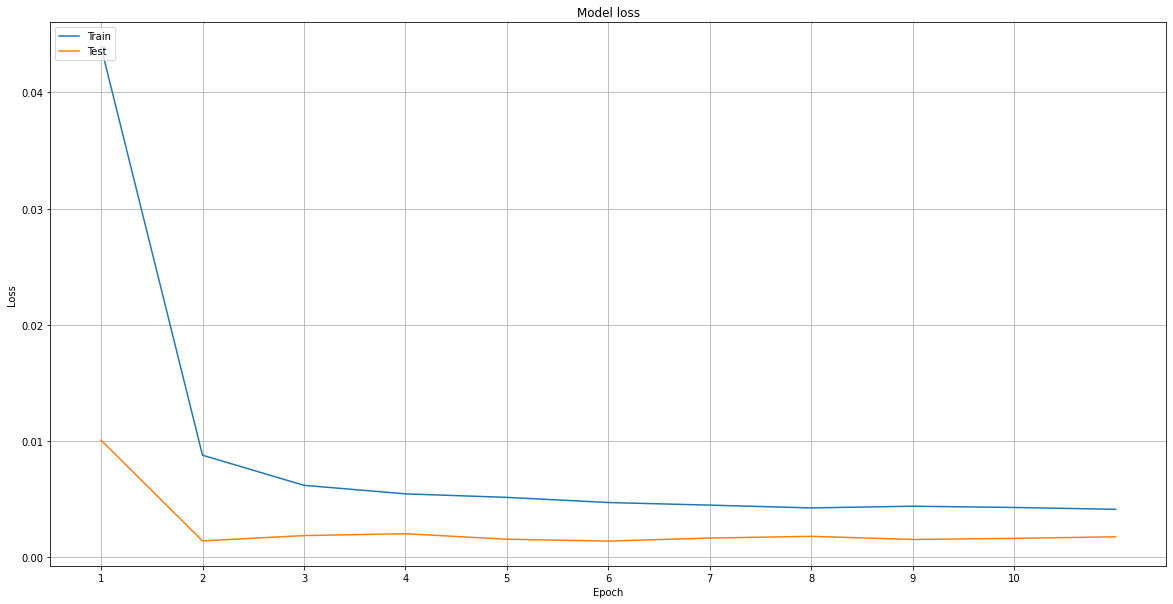

In [61]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [62]:
MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])

# Add results to dictionary
results_dict['{}_{}dayshift_MAE_baseline'.format(ticker, shift)] = MAE_list
results_dict['{}_{}dayshift_MAPE_baseline'.format(ticker, shift)] = MAPE_list
results_dict['{}_{}dayshift_MDAPE_baseline'.format(ticker, shift)] = MDAPE_list

results

Median Absolute Error (MAE): 0.56
Mean Absolute Percentage Error (MAPE): 5.74 %
Median Absolute Percentage Error (MDAPE): 5.79 %


,MAE,MAPE,MDAPE
0,0.56328,5.741175,5.792852


In [63]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid[dep_var[0]], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

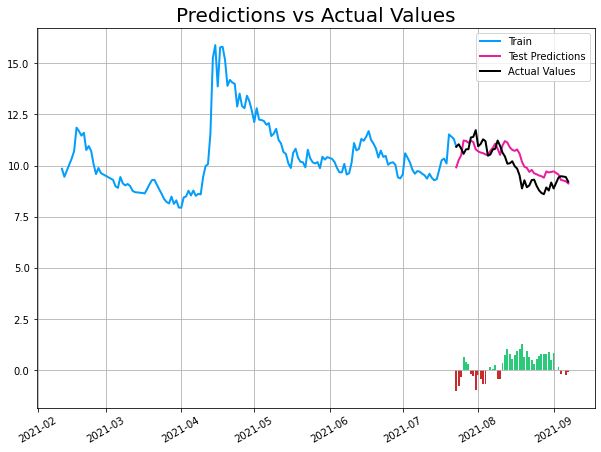

In [64]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="bottom left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.xticks(rotation = 30)

plt.grid()
plt.show()

## Overall Results

In [65]:
results_df =pd.DataFrame.from_dict(results_dict).transpose().reset_index()
results_df['ticker'] = results_df['index'].str.split('_').str[0]
results_df['shift'] = results_df['index'].str.split('_').str[1]
results_df['metric'] = results_df['index'].str.split('_').str[2]
results_df['scenario'] = results_df['index'].str.split('_').str[3]
results_df['scenario'].fillna(value = 'sentiment', inplace = True)
results_df['results_%'] = results_df[0]
results_df.drop(['index', 0], axis = 1, inplace = True)
results_df.sort_values(['metric', 'shift','scenario'], inplace = True)
results_df = results_df.pivot(index = ['shift', 'metric'], columns = 'scenario', values = 'results_%').reset_index()
results_df

scenario,shift,metric,baseline,sentiment
0,1dayshift,MAE,0.521468,0.519107
1,1dayshift,MAPE,5.104635,5.035980
2,1dayshift,MDAPE,2.652216,4.485480
3,4dayshift,MAE,0.554662,0.491548
4,4dayshift,MAPE,5.760614,4.912796
5,4dayshift,MDAPE,5.201170,4.309070
6,7dayshift,MAE,0.563280,0.601907
7,7dayshift,MAPE,5.741175,5.952361
8,7dayshift,MDAPE,5.792852,3.817238


In [66]:
results_df.to_csv('{}_LSTM.csv'.format(ticker), index = False)